<h1>Using R with Amazon SageMaker</h1>

This sample Notebook describes how to train, deploy, and retrieve predictions from a machine learning (ML) model using [Amazon SageMaker](https://aws.amazon.com/sagemaker/) and [R](https://www.r-project.org/). The model predicts abalone age as measured by the number of rings in the shell. The [reticulate](https://rstudio.github.io/reticulate/) package will be used as an R interface to [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/latest/index.html) to make API calls to Amazon SageMaker. The `reticulate` package translates between R and Python objects, and Amazon SageMaker provides a serverless data science environment to train and deploy ML models at scale.


<h3>Reticulating the Amazon SageMaker Python SDK</h3>

First, load the `reticulate` library and import the `sagemaker` Python module. Once the module is loaded, use the `$` notation in R instead of the `.` notation in Python to use available classes. 

In [1]:
library(reticulate)
sagemaker <- import('sagemaker')

<h3>Creating and accessing the data storage</h3>

The `Session` class provides operations for working with the following [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) resources with Amazon SageMaker:

* [S3](https://boto3.readthedocs.io/en/latest/reference/services/s3.html)
* [SageMaker](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker.html)
* [SageMakerRuntime](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker-runtime.html)

Let's create an [Amazon Simple Storage Service](https://aws.amazon.com/s3/) bucket for your data. 

In [3]:
session <- sagemaker$Session()
bucket <- session$default_bucket()

**Note** - The `default_bucket` function creates a unique Amazon S3 bucket with the following name: 

`sagemaker-<aws-region-name>-<aws account number>`

Specify the IAM role's [ARN](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) to allow Amazon SageMaker to access the Amazon S3 bucket. You can use the same IAM role used to create this Notebook:

In [4]:
role_arn <- sagemaker$get_execution_role()

<h3>Downloading and processing the dataset</h3>

The model uses the [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). First, download the data and start the [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis). Use tidyverse packages to read the data, plot the data, and transform the data into ML format for Amazon SageMaker:

In [5]:
library(readr)
data_file <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
abalone <- read_csv(file = data_file, col_names = FALSE)
names(abalone) <- c('sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings')
head(abalone)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)


sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


The output above shows that `sex` is a factor data type but is currently a character data type (F is Female, M is male, and I is infant). Change `sex` to a factor and view the statistical summary of the dataset:

In [6]:
abalone$sex <- as.factor(abalone$sex)
summary(abalone)

 sex          length         diameter          height        whole_weight   
 F:1307   Min.   :0.075   Min.   :0.0550   Min.   :0.0000   Min.   :0.0020  
 I:1342   1st Qu.:0.450   1st Qu.:0.3500   1st Qu.:0.1150   1st Qu.:0.4415  
 M:1528   Median :0.545   Median :0.4250   Median :0.1400   Median :0.7995  
          Mean   :0.524   Mean   :0.4079   Mean   :0.1395   Mean   :0.8287  
          3rd Qu.:0.615   3rd Qu.:0.4800   3rd Qu.:0.1650   3rd Qu.:1.1530  
          Max.   :0.815   Max.   :0.6500   Max.   :1.1300   Max.   :2.8255  
 shucked_weight   viscera_weight    shell_weight        rings       
 Min.   :0.0010   Min.   :0.0005   Min.   :0.0015   Min.   : 1.000  
 1st Qu.:0.1860   1st Qu.:0.0935   1st Qu.:0.1300   1st Qu.: 8.000  
 Median :0.3360   Median :0.1710   Median :0.2340   Median : 9.000  
 Mean   :0.3594   Mean   :0.1806   Mean   :0.2388   Mean   : 9.934  
 3rd Qu.:0.5020   3rd Qu.:0.2530   3rd Qu.:0.3290   3rd Qu.:11.000  
 Max.   :1.4880   Max.   :0.7600   Max.   :1.00

The summary above shows that the minimum value for `height` is 0.

Visually explore which abalones have height equal to 0 by plotting the relationship between `rings` and `height` for each value of `sex`:

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


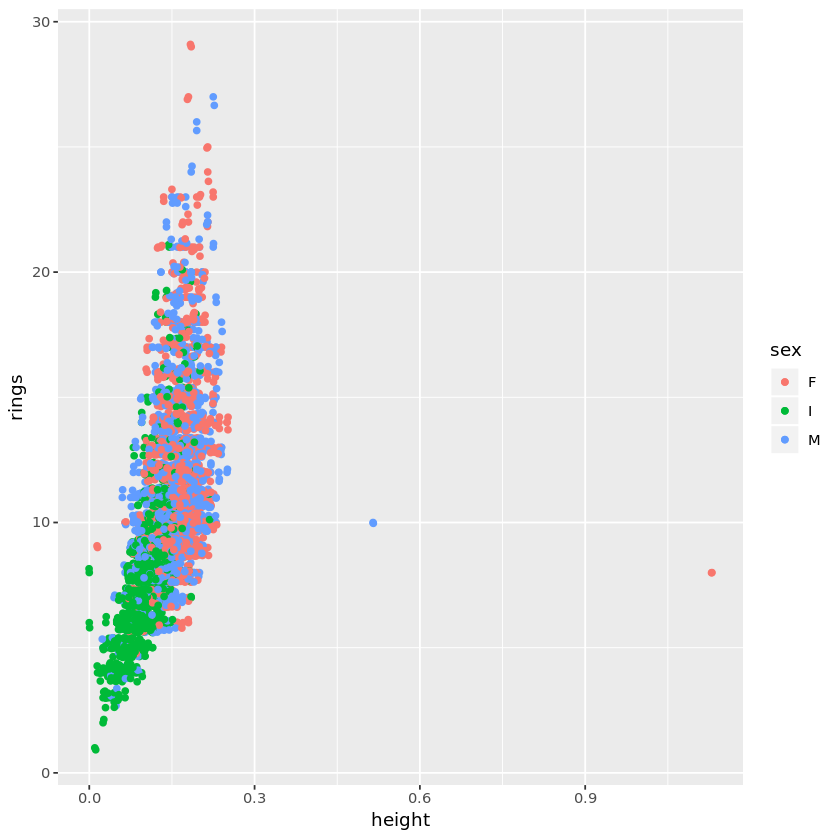

In [7]:
library(ggplot2)
ggplot(abalone, aes(x = height, y = rings, color = sex)) + geom_point() + geom_jitter()

The plot shows multiple outliers: two infant abalones with a height of 0 and a few female and male abalones with greater heights than the rest. Let's filter out the two infant abalones with a height of 0.

In [8]:
library(dplyr)
abalone <- abalone %>%
  filter(height != 0)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



<h3>Preparing the dataset for model training</h3>

The model needs three datasets: one each for training, testing, and validation. First, convert `sex` into a [dummy variable](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) and move the target, `rings`, to the first column. Amazon SageMaker algorithm require the target to be in the first column of the dataset.

In [9]:
abalone <- abalone %>%
  mutate(female = as.integer(ifelse(sex == 'F', 1, 0)),
         male = as.integer(ifelse(sex == 'M', 1, 0)),
         infant = as.integer(ifelse(sex == 'I', 1, 0))) %>%
  select(-sex)
abalone <- abalone %>%
  select(rings:infant, length:shell_weight)
head(abalone)

rings,female,male,infant,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
15,0,1,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
7,0,1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
9,1,0,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
10,0,1,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
7,0,0,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055
8,0,0,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120


Next, sample 70% of the data for training the ML algorithm. Split the remaining 30% into two halves, one for testing and one for validation:

In [10]:
abalone_train <- abalone %>%
  sample_frac(size = 0.7)
abalone <- anti_join(abalone, abalone_train)
abalone_test <- abalone %>%
  sample_frac(size = 0.5)
abalone_valid <- anti_join(abalone, abalone_test)

Joining, by = c("rings", "female", "male", "infant", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight")
Joining, by = c("rings", "female", "male", "infant", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight")


Upload the training and validation data to Amazon S3 so that you can train the model. First, write the training and validation datasets to the local filesystem in .csv format:

In [11]:
write_csv(abalone_train, 'abalone_train.csv', col_names = FALSE)
write_csv(abalone_valid, 'abalone_valid.csv', col_names = FALSE)

Second, upload the two datasets to the Amazon S3 bucket into the `data` key:

In [12]:
s3_train <- session$upload_data(path = 'abalone_train.csv', 
                                bucket = bucket, 
                                key_prefix = 'data')
s3_valid <- session$upload_data(path = 'abalone_valid.csv', 
                                bucket = bucket, 
                                key_prefix = 'data')

Finally, define the Amazon S3 input types for the Amazon SageMaker algorithm:

In [13]:
s3_train_input <- sagemaker$s3_input(s3_data = s3_train,
                                     content_type = 'csv')
s3_valid_input <- sagemaker$s3_input(s3_data = s3_valid,
                                     content_type = 'csv')

<h3>Training the model</h3>

Amazon SageMaker algorithm are available via a [Docker](https://www.docker.com/) container. To train an [XGBoost](https://en.wikipedia.org/wiki/Xgboost) model, specify the training containers in [Amazon Elastic Container Registry](https://aws.amazon.com/ecr/) (Amazon ECR) for the AWS Region.

In [14]:
registry <- sagemaker$amazon$amazon_estimator$registry(session$boto_region_name, algorithm='xgboost')
container <- paste(registry, '/xgboost:latest', sep='')

Define an Amazon SageMaker [Estimator](http://sagemaker.readthedocs.io/en/latest/estimators.html), which can train any supplied algorithm that has been containerized with Docker. When creating the Estimator, use the following arguments:
* **image_name** - The container image to use for training
* **role** - The Amazon SageMaker service role
* **train_instance_count** - The number of Amazon EC2 instances to use for training
* **train_instance_type** - The type of Amazon EC2 instance to use for training
* **train_volume_size** - The size in GB of the [Amazon Elastic Block Store](https://aws.amazon.com/ebs/) (Amazon EBS) volume to use for storing input data during training
* **train_max_run** - The timeout in seconds for training
* **input_mode** - The input mode that the algorithm supports
* **output_path** - The Amazon S3 location for saving the training results (model artifacts and output files)
* **output_kms_key** - The [AWS Key Management Service](https://aws.amazon.com/kms/) (AWS KMS) key for encrypting the training output
* **base_job_name** - The prefix for the name of the training job
* **sagemaker_session** - The Session object that manages interactions with Amazon SageMaker API

In [15]:
s3_output <- paste0('s3://', bucket, '/output')
estimator <- sagemaker$estimator$Estimator(image_name = container,
                                           role = role_arn,
                                           train_instance_count = 1L,
                                           train_instance_type = 'ml.m5.large',
                                           train_volume_size = 30L,
                                           train_max_run = 3600L,
                                           input_mode = 'File',
                                           output_path = s3_output,
                                           output_kms_key = NULL,
                                           base_job_name = NULL,
                                           sagemaker_session = NULL)

**Note** - The equivalent to `None` in Python is `NULL` in R.

Specify the [XGBoost hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) and fit the model. Set the number of rounds for training to 100 which is the default value when using the XGBoost library outside of Amazon SageMaker. Also specify the input data and a job name based on the current time stamp:

In [16]:
estimator$set_hyperparameters(num_round = 100L)
job_name <- paste('sagemaker-train-xgboost', format(Sys.time(), '%H-%M-%S'), sep = '-')
input_data <- list('train' = s3_train_input,
                   'validation' = s3_valid_input)
estimator$fit(inputs = input_data,
              job_name = job_name)

Once training has finished, Amazon SageMaker copies the model binary (a gzip tarball) to the specified Amazon S3 output location. Get the full Amazon S3 path with this command:

In [17]:
estimator$model_data

[1] "s3://sagemaker-ap-southeast-2-423079281568/output/sagemaker-train-xgboost-08-42-16/output/model.tar.gz"

<h3>Deploying the model</h3>

Amazon SageMaker lets you [deploy your model](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html) by providing an endpoint that consumers can invoke by a secure and simple API call using an HTTPS request. Let's deploy our trained model to a `ml.t2.medium` instance.

In [18]:
model_endpoint <- estimator$deploy(initial_instance_count = 1L,
                                   instance_type = 'ml.t2.medium')

<h3>Generating predictions with the model</h3>

Use the test data to generate predictions. Pass comma-separated text to be serialized into JSON format by specifying `text/csv` and `csv_serializer` for the endpoint:

In [19]:
model_endpoint$content_type <- 'text/csv'
model_endpoint$serializer <- sagemaker$predictor$csv_serializer

Remove the target column and convert the first 500 observations to a matrix with no column names:

In [20]:
abalone_test <- abalone_test[-1]
num_predict_rows <- 500
test_sample <- as.matrix(abalone_test[1:num_predict_rows, ])
dimnames(test_sample)[[2]] <- NULL

**Note** - 500 observations was chosen because it doesn't exceed the endpoint limitation.

Generate predictions from the endpoint and convert the returned comma-separated string:

In [21]:
library(stringr)
predictions <- model_endpoint$predict(test_sample)
predictions <- str_split(predictions, pattern = ',', simplify = TRUE)
predictions <- as.numeric(predictions)

Column-bind the predicted rings to the test data:

In [22]:
abalone_test <- cbind(predicted_rings = predictions, 
                      abalone_test[1:num_predict_rows, ])
head(abalone_test)

predicted_rings,female,male,infant,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
10.545817,0,1,0,0.470,0.360,0.135,0.5010,0.1665,0.1150,0.1650
18.334177,0,1,0,0.680,0.540,0.195,1.7825,0.5565,0.3235,0.4285
11.220117,1,0,0,0.635,0.510,0.170,1.2235,0.5320,0.2710,0.3540
8.885004,0,0,1,0.570,0.440,0.150,0.7550,0.3425,0.1600,0.2240
12.404117,0,1,0,0.685,0.535,0.155,1.3845,0.6615,0.2145,0.4075
8.718064,0,1,0,0.550,0.430,0.150,0.8745,0.4130,0.1905,0.2480


<h3>Deleting the endpoint</h3>

When you're done with the model, delete the endpoint to avoid incurring deployment costs:

In [ ]:
session$delete_endpoint(model_endpoint$endpoint)